In [1]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np

import gymnasium as gym
from gymnasium import spaces
import numpy as npimport 

import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
from pprint import pprint
from typing import List, Tuple, Dict, Any, Union

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


actions: [QB, RB, WR, TE, K, DEF]

state: [
    next 15 QB FP

    next 30 RB FP

    next 30 WR FP

    next 15 TE FP

    next 15 Ks FP

    next 15 DEF FP

    team comps: 6 positions * 12 managers

    n until next pick (scaled  /12)

    round (scaled scaled /15)
    
    ]
    

120 future players
current team = 6 spots for QBs, 6 spots for k, 6 spots for def, 9 spots for RB, 9 for WR, 8 for TE (this allows full starters and anything else) = 44
+1 for picks remaining
+1 for number of opp picks before next pick
166 total

or 330 if i include a variance with each player


reward function: sum fpts when starting lineup is full, 0 when starting lineup not full

In [2]:
df_sleeper = pd.read_csv("data/sleeper/all_players.csv")
# df_sleeper = df_sleeper.loc[df_sleeper["rank_int"] < 50]
print(df_sleeper.shape)
df_sleeper.columns

(3670, 56)


Index(['sleeper_id', 'injury_notes', 'oddsjam_id', 'search_last_name',
       'college', 'team_abbr', 'birth_state', 'yahoo_id', 'search_first_name',
       'pandascore_id', 'years_exp', 'fantasy_positions', 'injury_status',
       'active', 'team', 'competitions', 'high_school', 'number', 'birth_city',
       'search_full_name', 'last_name', 'birth_country',
       'practice_description', 'depth_chart_order', 'fantasy_data_id',
       'status', 'injury_start_date', 'news_updated', 'age', 'search_rank',
       'practice_participation', 'opta_id', 'full_name', 'swish_id',
       'birth_date', 'rotowire_id', 'weight', 'height', 'stats_id', 'espn_id',
       'metadata', 'player_id', 'first_name', 'sport', 'injury_body_part',
       'position', 'gsis_id', 'sportradar_id', 'hashtag',
       'depth_chart_position', 'rotoworld_id', 'Player Id', 'positional_rank',
       'adp', 'adp_date', 'rank_int'],
      dtype='object')

In [3]:
SCORING = {
    'pass_yd': .04,
    'pass_td': 4,
    'pass_2pt': 2,
    'pass_int': -1,
    'rush_yd': .1,
    'rush_td': 6,
    'rush_2pt': 2,
    'rec_rcpt': .5,
    'rec_yd': .1,
    'rec_td': 6,
    'rec_2pt': 2,
    'fg_1_39_made': 3,
    'fg_40_49_made': 4,
    'fg_50_made': 5,
    'xp_missed': -1,
    'xp_made': 1,
    'def_td': 6,
    'def_int': 2,
    'def_sck': 1,
    'def_fum_rec': 2,
    'def_fum_forced': 1,
    'def_sfty': 2,
    'remainder': 1
}

POSITIONS = ['QB', 'RB', 'WR', 'TE', 'K', 'DEF']
STARTER_COMPOSITION = {'QB': 1, 'RB': 2, 'WR': 2, 'FLEX': 2, 'TE': 1, 'K': 1, 'DEF': 1}
TEAM_SIZE = 15

In [4]:
df_qb_proj = pd.read_csv("data/projections/QB_projections.csv")
df_rb_proj = pd.read_csv("data/projections/RB_projections.csv")
df_wr_proj = pd.read_csv("data/projections/WR_projections.csv")
df_te_proj = pd.read_csv("data/projections/TE_projections.csv")
df_k_proj = pd.read_csv("data/projections/K_projections.csv")
df_def_proj = pd.read_csv("data/projections/DEF_projections.csv")

df_qb_proj = df_qb_proj.loc[:, ["sleeper_id", "full_name", "team", "position", "source", "fpts"]].sort_values(by="fpts", ascending=False)
df_rb_proj = df_rb_proj.loc[:, ["sleeper_id", "full_name", "team", "position", "source", "fpts"]].sort_values(by="fpts", ascending=False)
df_wr_proj = df_wr_proj.loc[:, ["sleeper_id", "full_name", "team", "position", "source", "fpts"]].sort_values(by="fpts", ascending=False)
df_te_proj = df_te_proj.loc[:, ["sleeper_id", "full_name", "team", "position", "source", "fpts"]].sort_values(by="fpts", ascending=False)
df_k_proj = df_k_proj.loc[:, ["sleeper_id", "full_name", "team", "position", "source", "fpts"]].sort_values(by="fpts", ascending=False)
df_def_proj = df_def_proj.loc[:, ["sleeper_id", "full_name", "team", "position", "source", "fpts"]].sort_values(by="fpts", ascending=False)

df_proj = pd.concat([df_qb_proj, df_rb_proj, df_wr_proj, df_te_proj, df_k_proj, df_def_proj])
df_proj.columns

df_proj_agg = df_proj.groupby('sleeper_id')['fpts'].agg(['mean', 'std']).reset_index()
df_proj_agg['sleeper_id'] = df_proj_agg['sleeper_id'].astype(str)


df_players = df_proj_agg.merge(df_sleeper.loc[:, ['sleeper_id', 'full_name', 'position', 'team']], 
                                on='sleeper_id', 
                                how='left')
print(df_players.shape)
df_players = df_players.dropna(subset=['mean', 'std'])
print(df_players.shape)




(796, 6)
(647, 6)


In [5]:
df_players.loc[df_players['position'] == 'K']

,sleeper_id,mean,std,full_name,position,team
0,17,121.511667,15.281820,Matt Prater,K,ARI
8,503,106.796667,18.603485,Graham Gano,K,NYG
11,650,118.843333,20.858074,Nick Folk,K,TEN
12,658,78.440000,110.930912,Mike Nugent,K,NaN
20,1099,20.100000,23.745105,Randy Bullock,K,NaN
23,1264,143.256667,6.830525,Justin Tucker,K,BAL
24,1266,131.338333,7.435349,Greg Zuerlein,K,NYJ
27,1348,126.546667,13.052428,Dustin Hopkins,K,CLE
31,1433,36.825000,39.208704,Brandon McManus,K,NaN
41,1945,119.438333,9.111730,Chris Boswell,K,PIT


In [6]:

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display
plt.ion()

# if GPU is to be used
device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu"
)



# Init environment and RL network

In [7]:
from rl_env import DraftEnv

from dqn import (
    DQN, ReplayMemory, Transition,
    NUM_MGRS, NUM_DRAFT_ROUNDS, ACTION_SPACE_DIM, 
    STATE_SPACE_DIM, STARTER_COMPOSITION
    )

In [8]:
# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the ``AdamW`` optimizer
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 100000
TAU = 0.005
LR = 1e-4

env = DraftEnv(df_players)

# Get number of actions from gym action space
n_actions = env.action_space.n
# Get the number of state observations
state, info = env.reset()
n_observations = len(state)

# mgr_networks = {i: {} for i in range(NUM_MGRS)}
# for mgr in mgr_networks.values():
#     mgr["policy"] = DQN(n_observations, n_actions).to(device)
#     mgr["target"] = DQN(n_observations, n_actions).to(device)
#     mgr["optimizer"] = optim.AdamW(mgr["policy"].parameters(), lr=LR, amsgrad=True)
#     mgr["memory"] = ReplayMemory(1000)
#     mgr["target"].load_state_dict(mgr["policy"].state_dict())

steps_done = 0

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)




In [9]:
# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the ``AdamW`` optimizer
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4
# LR = 1e-5

env = DraftEnv(df_players)

# Get number of actions from gym action space
n_actions = env.action_space.n
# Get the number of state observations
state, info = env.reset()
n_observations = len(state)


steps_done = 0



In [10]:

def select_action(state, policy_net, env, device):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1).indices.view(1, 1)
    else:
        if random.random() < 0.5:
            return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)
        else:
            return torch.tensor([[env.reasonable_option()]], device=device, dtype=torch.long)


def optimize_model(memory, policy_net, target_net, optimizer):
    if len(memory) < BATCH_SIZE:
        return 
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1).values
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()
    
    return loss

In [11]:
if torch.cuda.is_available() or torch.backends.mps.is_available():
    num_episodes = 50000
    # num_episodes = 50
else:
    num_episodes = 50

drafts = []
losses = []
rewards = []

# losses = np.zeros(num_episodes * NUM_DRAFT_ROUNDS)
# rewards = np.zeros(num_episodes * NUM_DRAFT_ROUNDS)


In [28]:

RL_MGR = 1
for i_episode in range(num_episodes):
    if i_episode < 1877:
        continue
    
    env.reset()
    print(f"Episode: {i_episode}")
    state = None
    for _, row in env.draft.iterrows():
        
        if row['mgr'] == RL_MGR:
            
            if state is not None: # ignore this part for the first iteration of the draft
                # Once you can observe the next state, ie after other players have gone,
                # you can store the transition in memory and optimize the model
                next_state = torch.tensor(env.get_state(), dtype=torch.float32, device=device).unsqueeze(0)
                memory.push(state, action, next_state, reward) # deal with first iteration
                loss = optimize_model(memory, policy_net, target_net, optimizer)
                losses.append(loss.item() if loss is not None else 0)
                # Soft update of the target network's weights
                # θ′ ← τ θ + (1 −τ )θ′
                target_net_state_dict = target_net.state_dict()
                policy_net_state_dict = policy_net.state_dict()
                for key in policy_net_state_dict:
                    target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
                    
                target_net.load_state_dict(target_net_state_dict)
            
            
            # Now we will initiate the next action selection
            state = torch.tensor(env.get_state(), dtype=torch.float32, device=device).unsqueeze(0)
            
            action = select_action(state, policy_net, env, device)
            observation, reward, terminated, info = env.step(action.item())
            reward = torch.tensor([reward], dtype=torch.float32, device=device)

            rewards.append(reward.item())
            drafts.append(env.draft.copy())
            
            # deal with case of last pick of draft
            if terminated:
                next_state = None
                memory.push(state, action, next_state, reward)
                loss = optimize_model(memory, policy_net, target_net, optimizer)
                losses.append(loss.item() if loss is not None else 0)
                # Soft update of the target network's weights
                # θ′ ← τ θ + (1 −τ )θ′
                target_net_state_dict = target_net.state_dict()
                policy_net_state_dict = policy_net.state_dict()
                for key in policy_net_state_dict:
                    target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
                target_net.load_state_dict(target_net_state_dict)
            
        else:
            env.step(env.reasonable_option())
            

    if i_episode % 100 == 0:
        # save the model
        print(f'Saving model: Episode {i_episode}')
        torch.save(policy_net.state_dict(), f"models/rl_draft_model_{i_episode}.pt")
    print(f"Running average reward:{np.sum(rewards[-15:])}")
    print(f"Running average loss: {np.mean(losses[-15:])}")
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
    print(f"Epsilon: {eps_threshold}")

        
print('Complete')


Episode: 1877
Running average reward:1.7072346676141024
Running average loss: 0.013668580663700898
Epsilon: 0.05000000000046002
Episode: 1878
Running average reward:2.9295783303678036
Running average loss: 0.0132000882178545
Epsilon: 0.05000000000045317
Episode: 1879
Running average reward:2.9483540672808886
Running average loss: 0.014356073737144471
Epsilon: 0.05000000000044642
Episode: 1880
Running average reward:2.9254916459321976
Running average loss: 0.01562734420100848
Epsilon: 0.050000000000439776
Episode: 1881
Running average reward:2.932237299159169
Running average loss: 0.015020045451819897
Epsilon: 0.050000000000433226
Episode: 1882
Running average reward:2.9483540672808886
Running average loss: 0.015079380571842193
Epsilon: 0.05000000000042678
Episode: 1883
Running average reward:2.104923604056239
Running average loss: 0.013849561537305514
Epsilon: 0.05000000000042042
Episode: 1884
Running average reward:2.5791986007243395
Running average loss: 0.014364393490056197
Epsilon:

KeyboardInterrupt: 

In [14]:
# set max number of rows 
pd.set_option('display.max_rows', 500)
# env.draft
env.get_mgr_draft(1)

,round,mgr,sleeper_id,full_name,team,position,team_pos,fp_mean,fp_std
1,0,1,6904,Jalen Hurts,PHI,QB,QB,0.984445,45.210711
22,1,1,8150,Kyren Williams,LAR,RB,RB,0.625078,13.991141
25,2,1,6797,Justin Herbert,LAC,QB,QB,0.787189,39.905263
46,3,1,11533,Brandon Aubrey,DAL,K,K,0.375178,4.589032
49,4,1,4983,DJ Moore,CHI,WR,WR,0.543606,28.373901
70,5,1,4066,Evan Engram,JAX,TE,TE,0.421275,22.446061
73,6,1,NYJ,New York Jets,NYJ,DEF,DEF,0.410554,45.05841
94,7,1,6130,Devin Singletary,NYG,RB,RB,0.450854,32.788531
97,8,1,2749,Raheem Mostert,MIA,RB,RB,0.446248,23.516414
118,9,1,5045,Courtland Sutton,DEN,WR,WR,0.388763,11.319653


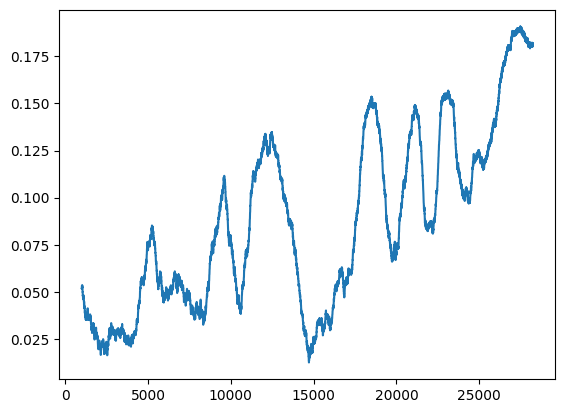

In [27]:
# plot rolling mean of rewards
plt.plot(pd.Series(rewards).rolling(1000).mean())
plt.show()


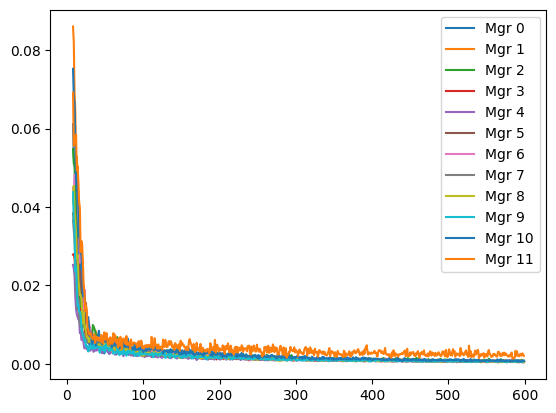

In [11]:

# plot losses for each manager
for i, loss in losses.items():
    plt.plot(loss)
# add legend for each manager
plt.legend([f"Mgr {i}" for i in losses.keys()])
plt.ioff()
plt.show()


In [12]:

# pd.set_option('display.max_rows', None)  # Show all rows
# pd.set_option('display.max_columns', None)  # Show all columns
# pd.set_option('display.width', None)  # Automatically adjust the display width
# pd.set_option('display.max_colwidth', None)  # Show full content of each column
# # display(env.draft.loc[env.draft["mgr"] == 0])
# display(env.)
# pd.reset_option('display.max_rows')
# pd.reset_option('display.max_columns')
# pd.reset_option('display.width')
# pd.reset_option('display.max_colwidth')

print(env.draft.loc[env.draft["mgr"] == 0])
# env.compute_reward(1)

for i in range(NUM_MGRS):
    print(f"Manager {i} reward: {env.compute_reward(i)}")

     round  mgr sleeper_id            full_name team position   fp_mean  \
0        0    0       4984           Josh Allen  BUF       QB       1.0   
23       1    0       4892       Baker Mayfield   TB       QB  0.736689   
24       2    0       8155          Breece Hall  NYJ       RB  0.714236   
47       3    0       8205        Isiah Pacheco   KC       RB  0.584847   
48       4    0       5850          Josh Jacobs   GB       RB  0.580631   
71       5    0       7611  Rhamondre Stevenson   NE       RB  0.487682   
72       6    0       7611  Rhamondre Stevenson   NE       RB  0.487682   
95       7    0       6130     Devin Singletary  NYG       RB  0.450854   
96       8    0      11533       Brandon Aubrey  DAL        K  0.375178   
119      9    0      11533       Brandon Aubrey  DAL        K  0.375178   
120     10    0      11533       Brandon Aubrey  DAL        K  0.375178   
143     11    0       5248          Gus Edwards  LAC       RB  0.356908   
144     12    0       524

In [36]:
drafts[-8].loc[drafts[-8]["mgr"] == 1]

,round,mgr,sleeper_id,full_name,team,position,team_pos,fp_mean,fp_std
1,0,1,4034,Christian McCaffrey,SF,RB,RB,0.862532,25.370947
22,1,1,8150,Kyren Williams,LAR,RB,RB,0.625078,13.991141
25,2,1,1466,Travis Kelce,KC,TE,TE,0.516778,26.221593
46,3,1,6803,Brandon Aiyuk,SF,WR,WR,0.545252,29.249867
49,4,1,2449,Stefon Diggs,HOU,WR,WR,0.53804,31.376697
70,5,1,7523,Trevor Lawrence,JAX,QB,QB,0.78856,37.307794
73,6,1,6801,Tee Higgins,CIN,WR,FLEX,0.512555,28.265377
94,7,1,4666,Younghoe Koo,ATL,K,K,0.368366,23.626646
97,8,1,2749,Raheem Mostert,MIA,RB,FLEX,0.446248,23.516414
118,9,1,NO,New Orleans Saints,NO,DEF,DEF,0.371778,38.756575
